In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(palette='viridis', font_scale=2, font='times', style='white')

regions = ['nsw', 'sa']
y_axis_var = 'net_load'

dfs = []
for region in regions:
    df = pd.read_csv(f'../data/{region}/merged.csv')
    df.datetime = df.datetime.astype('datetime64')
    df['region'] = region
    dt = df['datetime'].dt
    df['date'] = dt.date
    df['year'] = dt.year
    df['month'] = dt.month
    df['day'] = dt.day
    df['hour'] = dt.hour
    df['minute'] = dt.minute
    df['day_of_week'] = dt.weekday.astype('str') + '-' + dt.day_name().str[:3]
    df['isoyear'] = dt.isocalendar().year
    df['week'] = dt.isocalendar().week
    df['day_of_year'] = dt.day_of_year
    df['week_of_month'] = (dt.day - 1) // 7 # day of month - 1 (0-30) // 7 (0-6=0, 7-13=1, 14-20=2, 21-27=3, 28-x=4)
    dfs.append(df)
df = pd.concat(dfs)
df.head()

,datetime,net_load,total_load,pv_est,tempc_cbr,cloud8_cbr,windk_cbr,wdir_cbr,humid_cbr,rainmm_cbr,...,week,day_of_year,week_of_month,tempc,cloud8,windk,wdir,humid,rainmm,radkjm2
0,2018-03-06 10:00:00,8499.5,8332.145,434.3715,19.0,2.0,15.0,110.0,52.0,0.0,...,10,65,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-03-06 11:00:00,8457.0,8294.325,468.8860,19.4,1.0,14.0,140.0,49.0,0.0,...,10,65,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-03-06 12:00:00,8396.0,8248.405,483.1315,19.1,4.0,15.0,150.0,52.0,0.0,...,10,65,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-03-06 13:00:00,8341.5,8193.080,491.4175,19.4,4.0,14.0,140.0,55.0,0.0,...,10,65,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-03-06 14:00:00,8321.5,8185.100,487.9780,18.9,7.0,17.0,120.0,57.0,0.0,...,10,65,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


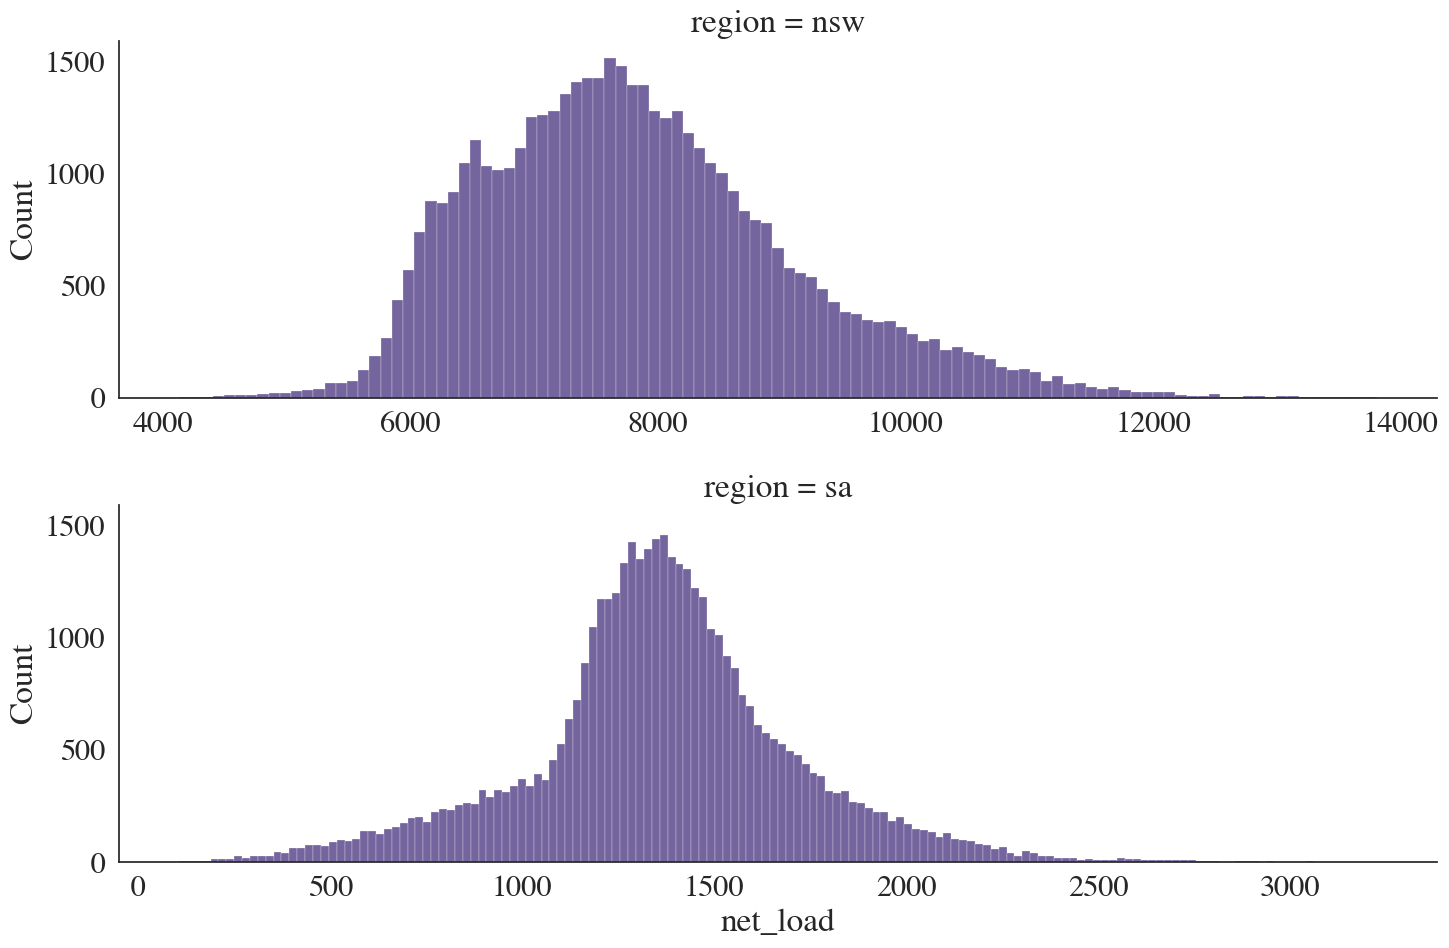

In [96]:
g = sns.displot(df.set_index(['datetime', 'region']), x='net_load', row='region', kind='hist', aspect=3,
                facet_kws={'sharex': False}, common_bins=False)
g.savefig('../plots/net_load_hist')

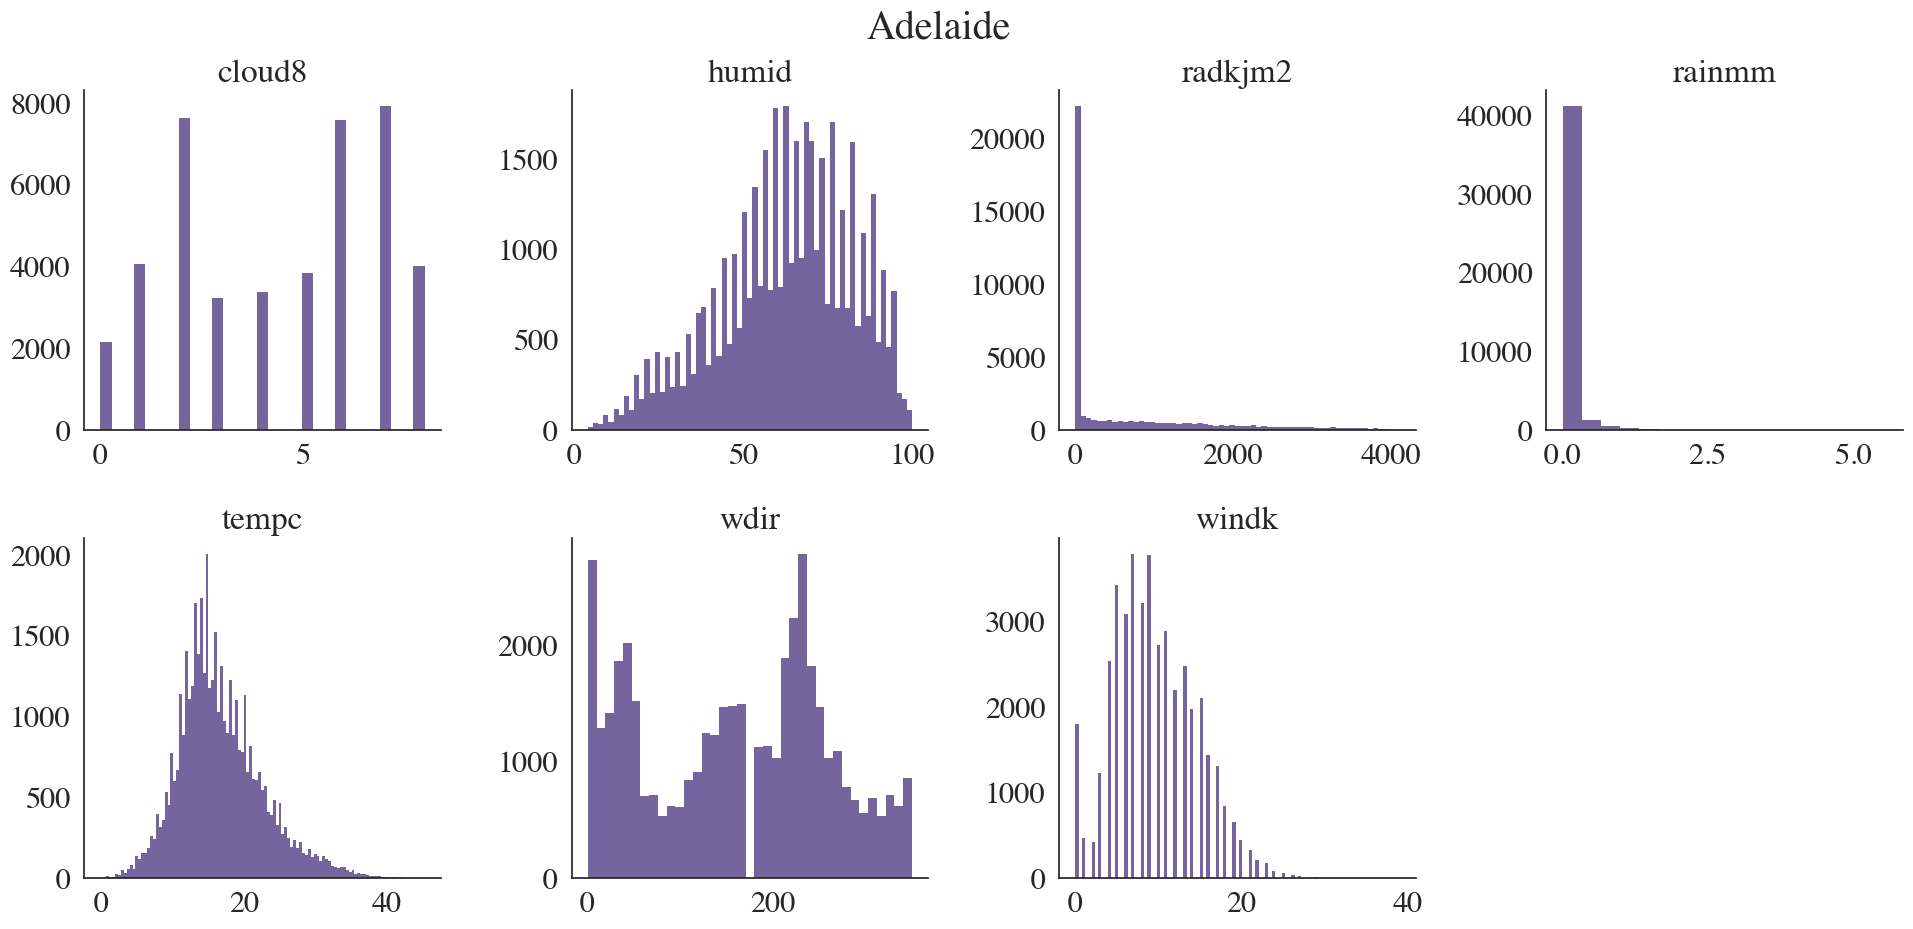

In [97]:
hist_ids = ['datetime', 'region']
hist_vals = ['cloud8', 'humid', 'radkjm2', 'rainmm', 'tempc', 'wdir', 'windk']
hist_df = df[df['region'] == 'sa'].melt(id_vars=hist_ids, value_vars=hist_vals)
g = sns.displot(hist_df, x='value', col='variable', col_wrap=4, kind='hist',
            facet_kws={'sharex': False, 'sharey': False}, common_bins=False)
g.set_axis_labels('', '')
g.set_titles('{col_name}')
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Adelaide')
g.savefig('../plots/weather_hist_ade')

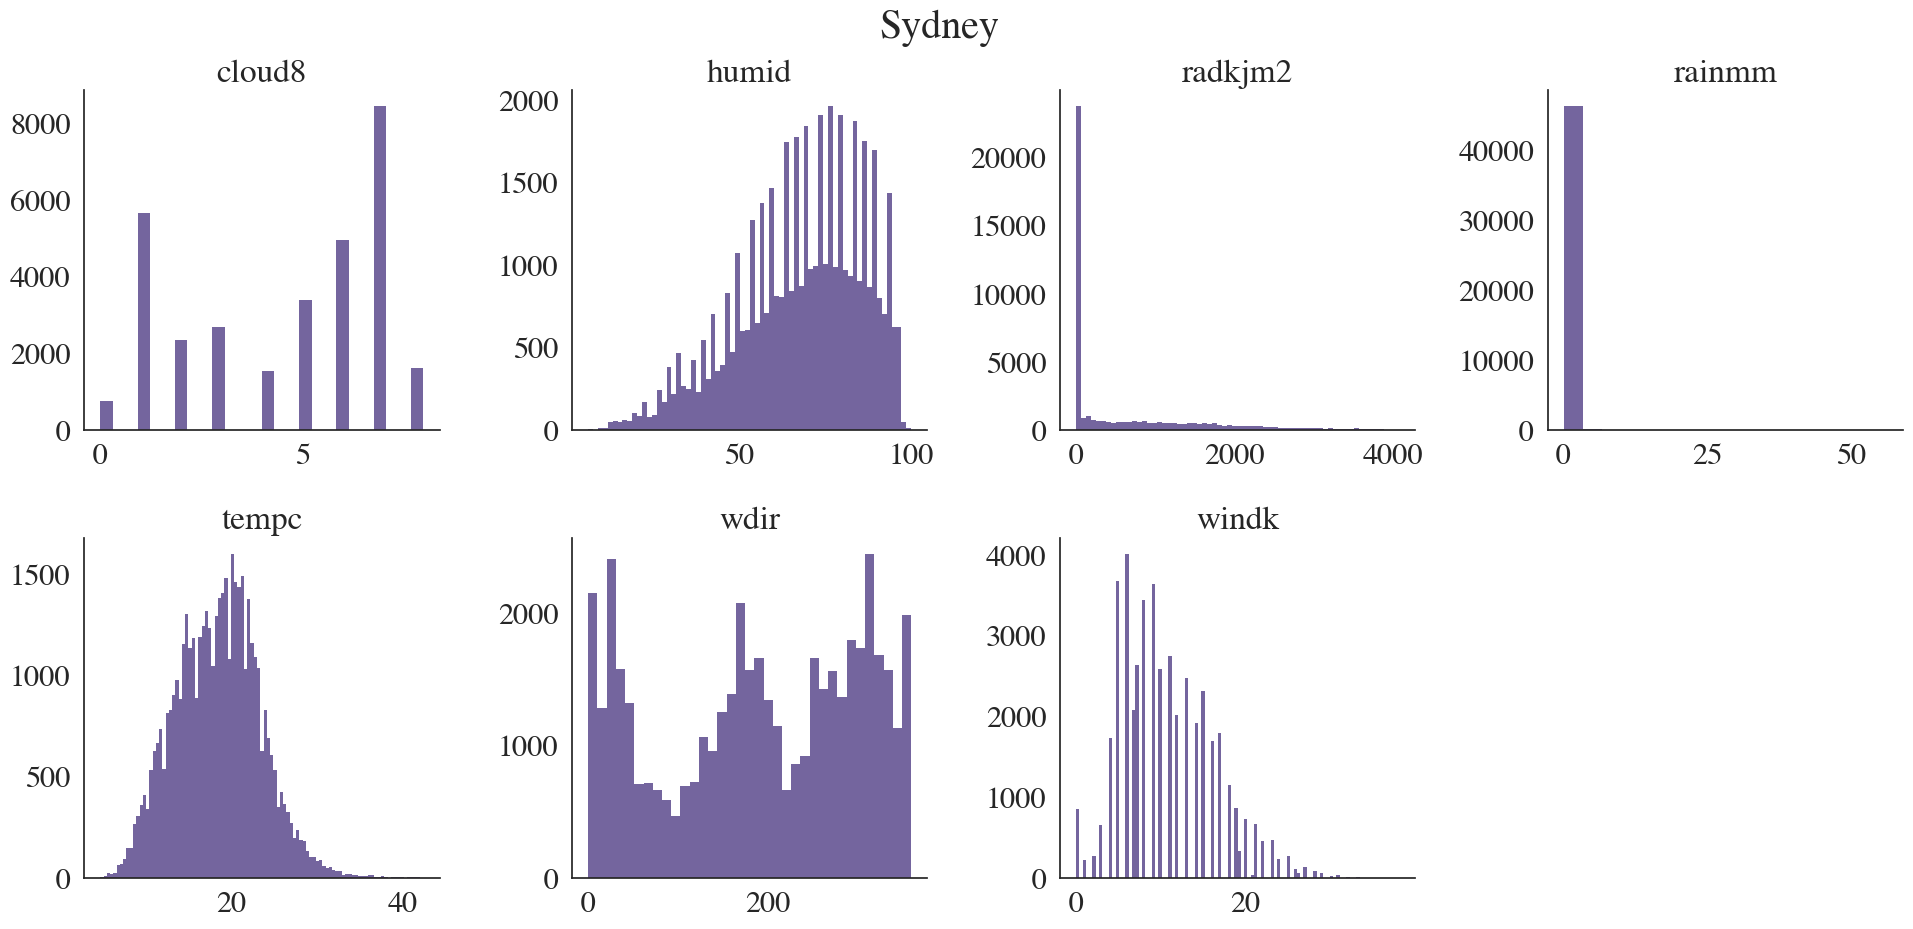

In [98]:
hist_vals_syd = [x + '_syd' for x in hist_vals]
hist_df = df[df['region'] == 'nsw'][hist_ids + hist_vals_syd].rename(
    {old: new for old, new in zip(hist_vals_syd, hist_vals)}, axis=1).melt(
        id_vars=hist_ids, value_vars=hist_vals)
g = sns.displot(hist_df, x='value', col='variable', col_wrap=4, kind='hist',
            facet_kws={'sharex': False, 'sharey': False}, common_bins=False)
g.set_axis_labels('', '')
g.set_titles('{col_name}')
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Sydney')
g.savefig('../plots/weather_hist_syd')

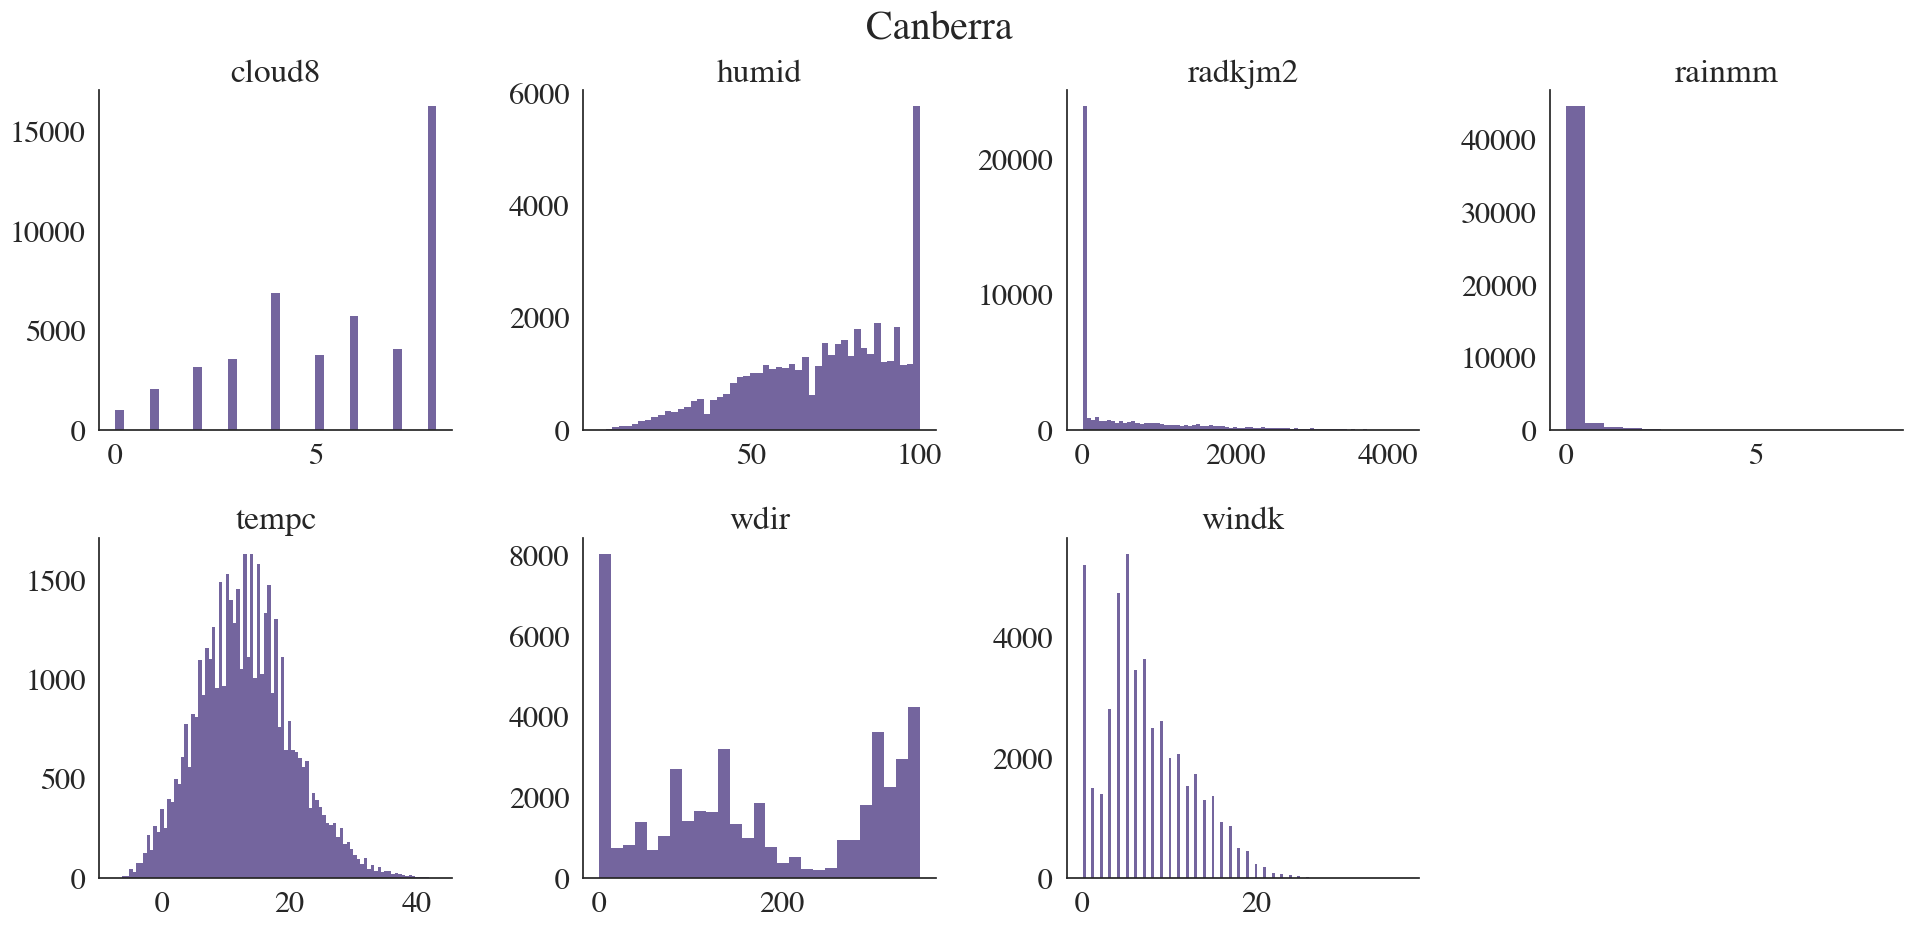

In [99]:
hist_vals_syd = [x + '_cbr' for x in hist_vals]
hist_df = df[df['region'] == 'nsw'][hist_ids + hist_vals_syd].rename(
    {old: new for old, new in zip(hist_vals_syd, hist_vals)}, axis=1).melt(
        id_vars=hist_ids, value_vars=hist_vals)
g = sns.displot(hist_df, x='value', col='variable', col_wrap=4, kind='hist',
            facet_kws={'sharex': False, 'sharey': False}, common_bins=False)
g.set_axis_labels('', '')
g.set_titles('{col_name}')
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Canberra')
g.savefig('../plots/weather_hist_cbr')

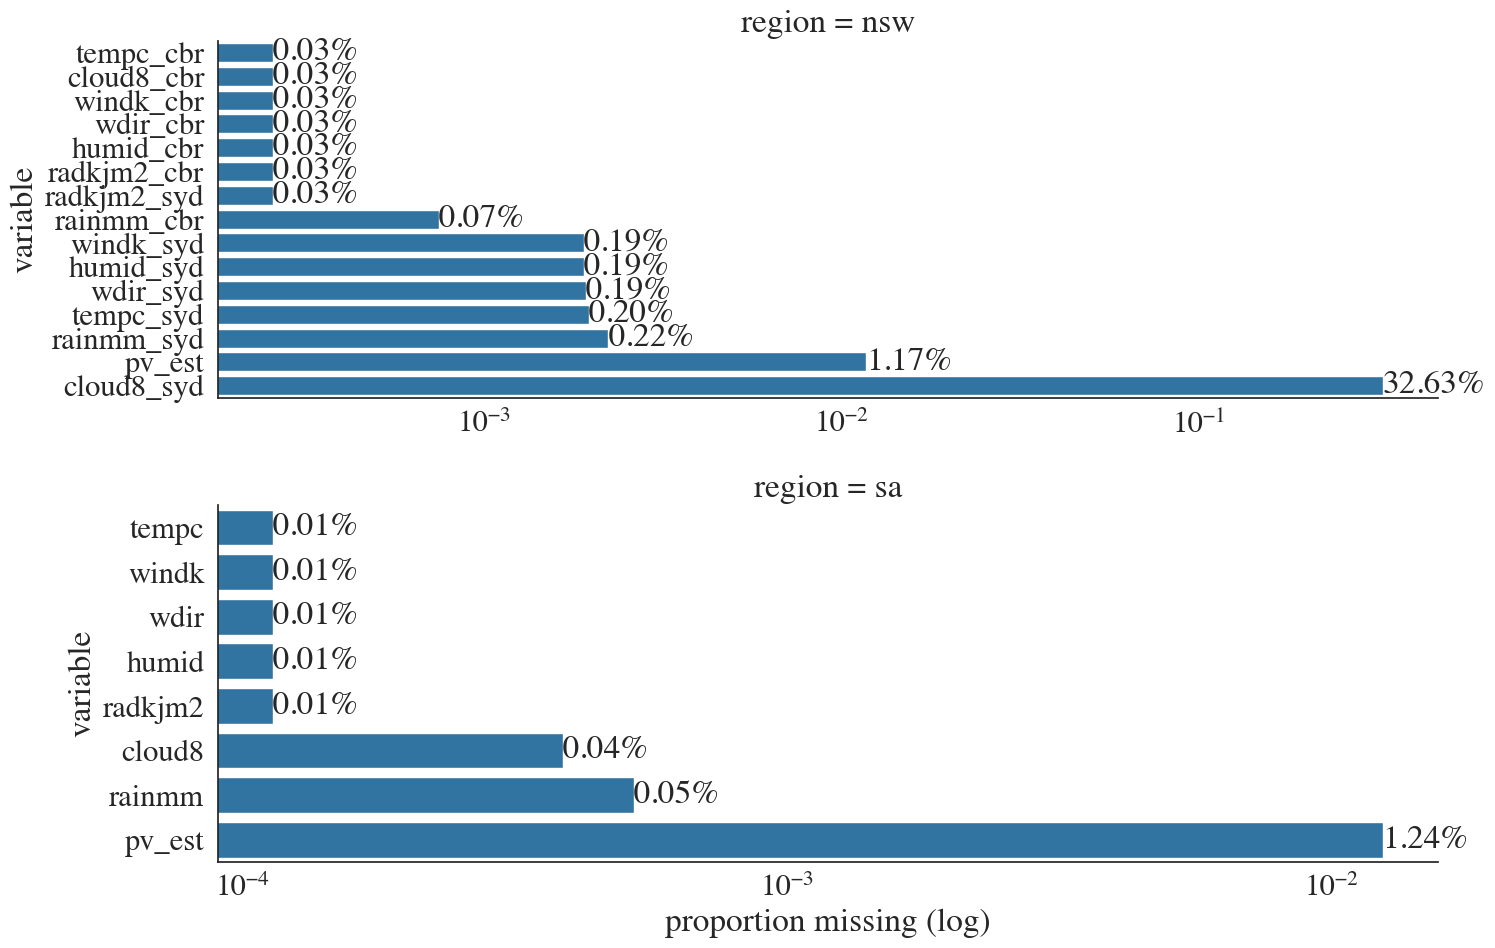

In [109]:
missing = []
for r, d in zip(regions, dfs):
    miss = d.isna().sum() / len(d)
    miss = miss[miss > 0].sort_values().to_frame()
    miss.columns = ['proportion missing (log)']
    miss.index.variables = ['variable']
    miss['variable'] = miss.index
    miss['region'] = r
    missing.append(miss)
missing_df = pd.concat(missing)
ax = sns.catplot(y='variable', x='proportion missing (log)', data=missing_df, row='region', 
                 kind='bar', sharex=False, sharey=False, aspect=3, color='tab:blue')
for x in ax.axes.ravel():
    for c in x.containers:
        labels = [f"{round(v.get_width(), 4):.2%}" for v in c]
        x.bar_label(c, labels=labels, label_type='edge')
ax = ax.set(xscale='log')
ax.savefig('../plots/missing_bar.png')

In [101]:
#df_na = df.set_index(['datetime', 'region'])[missing_df.index.unique()].isna()
#plot_na = df_na.reset_index().melt(id_vars=['datetime', 'region'], value_vars=missing_df.index.unique(), value_name='missing')
#g = sns.relplot(plot_na, x='datetime', y='missing', hue='variable', row='region', aspect=3)
# g.savefig('../plots/missing_scatter')

In [102]:
df_na = df.set_index(['datetime', 'region'])[missing_df.index.unique()].isna()
# df_na[:, 'sa'].apply(np.any, axis=1).mean()       # must be regional to be meaningful